In [1]:
import mglearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus']= False
import warnings
warnings.filterwarnings('ignore', category= FutureWarning)

In [2]:
citibike= mglearn.datasets.load_citibike()

print('시티 바이크 데이터: ', citibike.head())

시티 바이크 데이터:  starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, '대여 횟수')

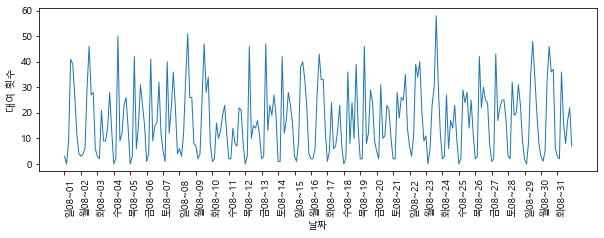

In [3]:
plt.figure(figsize= (10, 3))

xticks= pd.date_range(start= citibike.index.min(), end= citibike.index.max(), freq='D')

week= ['월', '화', '수', '목', '금', '토', '일']
xticks_name= [week[int(w)]+ d for w, d in zip(xticks.strftime('%w'),
                                               xticks.strftime('%m~%d'))]

plt.xticks(xticks, xticks_name, rotation= 90, ha= 'left')
plt.plot(citibike, linewidth= 1)
plt.xlabel('날짜')
plt.ylabel('대여 횟수')

### POSIX 시간만 사용하여 랜덤 포레스트 예측

In [4]:
y= citibike.values
# POSIX 시간을 10**9으로 나뉘어 변환
x= citibike.index.astype('int64').values.reshape(-1, 1)

In [5]:
# 184개의 데이터 포인트를 훈련 세트로 사용하고, 나머지를 테스트 세트로 사용
n_train= 184

# 주어진 특성을 사용하여 평가하고, 그래프 생성
def eval_on_features(features, target, regressor):
    # 훈련 세트와 테스트 세트 분활
    x_train, x_test= features[: n_train], features[n_train: ]
    # 타깃 값도 분활
    y_train, y_test= target[: n_train], target[n_train: ]
    regressor.fit(x_train, y_train)
    print('테스트 세트 R^2: {:.2f}'.format(regressor.score(x_test, y_test)))
    y_pred_test= regressor.predict(x_test)
    y_pred_train= regressor.predict(x_train)
    plt.figure(figsize= (10, 3))
    
    plt.xticks(range(0, len(x), 8), xticks_name, rotation= 90, ha= 'left')
    
    plt.plot(range(n_train), y_train, label= '훈련')
    plt.plot(range(n_train, len(y_test)+n_train), y_test, '-', label= '테스트')
    plt.plot(range(n_train), y_pred_train, '--', label= '훈련 예측')
    plt.plot(range(n_train, len(y_test)+n_train), y_pred_test, '-', label= '테스트 예측')
    plt.legend(loc= (1.01, 0))
    plt.xlabel('날짜')
    plt.ylabel('대여 횟수')

In [6]:
from sklearn.ensemble import RandomForestRegressor

테스트 세트 R^2: -0.04


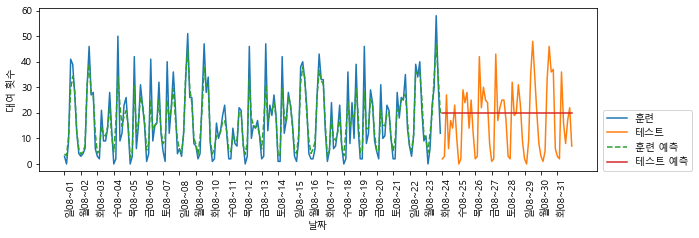

In [7]:
regressor= RandomForestRegressor(n_estimators= 100, random_state= 0)
eval_on_features(x, y, regressor)

### 시간만 사용하여 랜덤 포레스트 예측

테스트 세트 R^2: 0.60


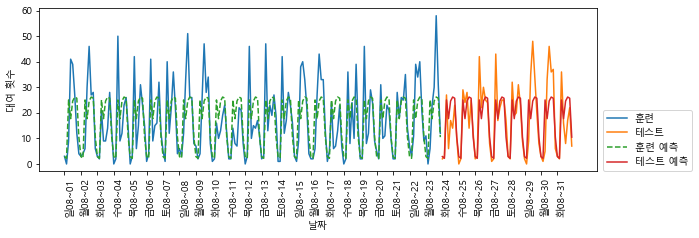

In [8]:
x_hour= citibike.index.hour.values.reshape(-1, 1)
eval_on_features(x_hour, y, regressor)

### 시간과 요일을 사용하여 랜덤 포레스트 예측

테스트 세트 R^2: 0.84


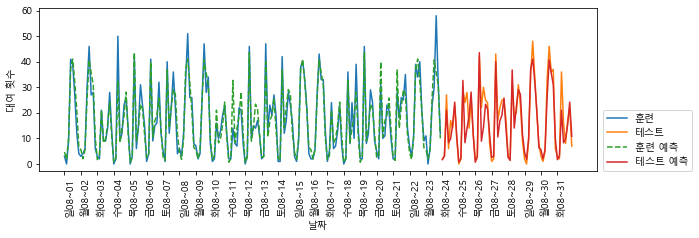

In [9]:
x_hour_week= np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                        citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(x_hour_week, y, regressor)

### 시간과 요일을 사용하여 선형 회귀 예측

In [10]:
from sklearn.linear_model import LinearRegression

테스트 세트 R^2: 0.13


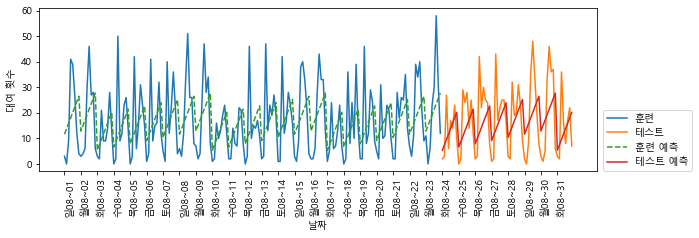

In [11]:
eval_on_features(x_hour_week, y, LinearRegression())

### 시간과 요일을 원핫 인코딩을 사용하여 선형 회귀 예측

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

테스트 세트 R^2: 0.62


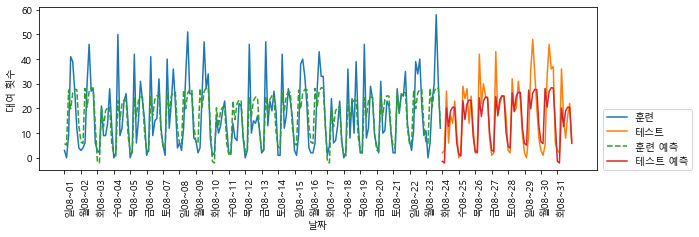

In [13]:
enc= OneHotEncoder()
x_hour_week_encoder= enc.fit_transform(x_hour_week).toarray()
eval_on_features(x_hour_week_encoder, y, Ridge())

### 시간과 요일의 곱한 특성을 사용하여 선형 회귀 예측

In [14]:
from sklearn.preprocessing import PolynomialFeatures

테스트 세트 R^2: 0.85


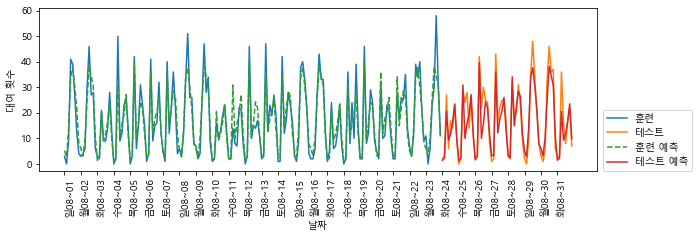

In [15]:
poly_transformer= PolynomialFeatures(degree= 2, interaction_only= True,
                                      include_bias= False)
x_hour_week_encoder_poly= poly_transformer.fit_transform(x_hour_week_encoder)
lr= Ridge()
eval_on_features(x_hour_week_encoder_poly, y, lr)

### 선형 모델 계수

In [16]:
hour= ['%02d:00'% i for i in range(0, 24, 3)]
day= ['월', '화', '수', '목', '금', '토', '일']
features= day + hour

In [17]:
features_poly= poly_transformer.get_feature_names_out(features)
features_nonzero= np.array(features_poly)[lr.coef_ != 0]
coef_nonzero= lr.coef_[lr.coef_ != 0]

Text(0, 0.5, '계수 크기')

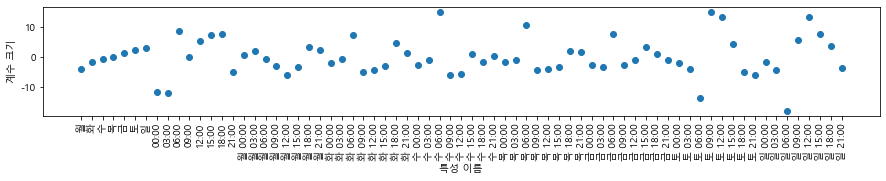

In [18]:
plt.figure(figsize= (15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation= 90)
plt.xlabel('특성 이름')
plt.ylabel('계수 크기')